## CMGP: Train and Evaluation

This notebook presents the solution for training and evaluating CMGP.

The implementation of CMGP is adapted in the local `ite` library.

First, make sure that all the depends are installed.
```
pip install -r requirements.txt
pip install .
```

### Setup

First, we import all the dependencies necessary for the task.

In [8]:
# Double check that we are using the correct interpreter.
import sys
print(sys.executable)
    
# Import depends
import ite.algs.causal_multitask_gaussian_processes.model as alg
import ite.datasets as ds
import ite.utils.numpy as utils
import numpy as np

from matplotlib import pyplot as plt

/home/bcebere/anaconda3/envs/cambridge/bin/python


### Load the Dataset

For CGMP, we have to downsample to 1000 training items.

In [9]:
train_ratio = 0.8
 
dataset = ds.load("twins", train_ratio, downsample=1000)
[Train_X, Train_T, Train_Y, Opt_Train_Y, Test_X, Test_Y] = dataset

### Load the model

In [10]:
dim = len(Train_X[0])
dim_outcome = Test_Y.shape[1]
        
model = alg.CMGP(
    dim=dim,
    dim_outcome=dim_outcome,
    max_gp_iterations=500,
)

assert model is not None

### Run experiments

In [13]:
plot_experiments: dict = {
    "train_sqrt_PEHE": [],
    "test_sqrt_PEHE": [],
}
    
for experiment in range(6):
    dataset = ds.load(
        "twins",
        train_ratio,
        downsample=1000,
    )
 
    metrics = model.train(*dataset)

### Plot experiments metrics

in-sample metrics:
 - sqrt_PEHE: 0.288 +/- 0.008
 - ATE: 0.018 +/- 0.006
out-sample metrics:
 - sqrt_PEHE: 0.296 +/- 0.007
 - ATE: 0.018 +/- 0.005


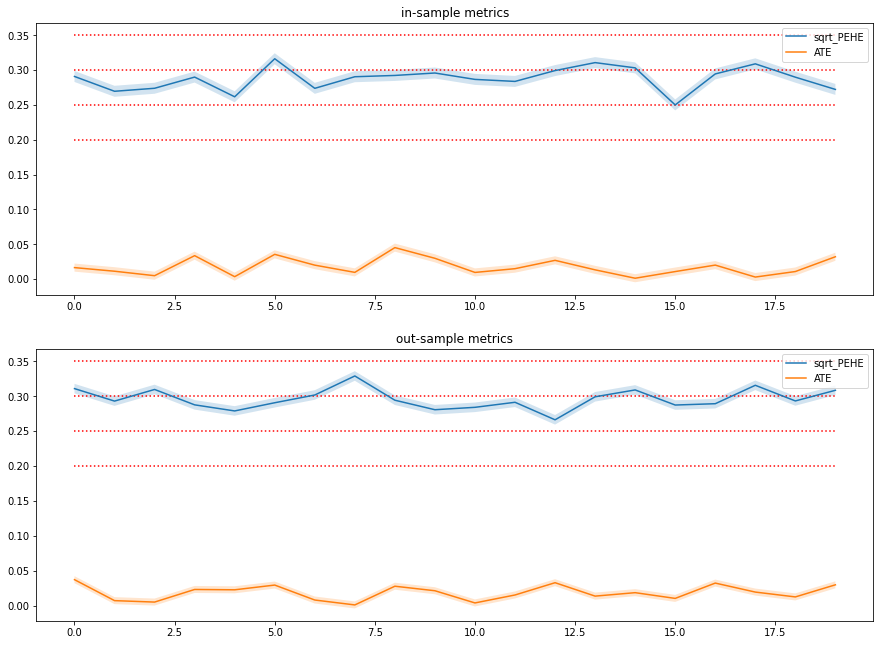

In [14]:
metrics.print()

metrics.plot(plt, with_ci=True, thresholds=[0.2, 0.25, 0.3, 0.35])

### Predict

In [19]:
hat_y = model.predict(Test_X)
utils.sqrt_PEHE(hat_y.to_numpy(), Test_Y)

0.3045921948921132

### Test
Will can run inferences and get metrics directly

In [20]:
metrics = model.test(Test_X, Test_Y)
 
metrics.print()

sqrt_PHE = 0.305
ATE = 0.052
